In [1]:
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta, date
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [55]:
path_to_data='/scratch/spf248/covid/data'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
city_id='UC_NM_MN'
demographics=['WEALTH_INDEX','AGE']
min_pings=10
inputs_folders=sorted([x.split('/')[-1][:-2] for x in glob(os.path.join(path_to_data,source,'s3',country,'*'))])
start_date=pd.to_datetime(inputs_folders[0],format='%Y%m%d').strftime('%m/%d/%Y')
end_date=pd.to_datetime(inputs_folders[-1],format='%Y%m%d').strftime('%m/%d/%Y')
min_days=len(inputs_folders)//2
print('Start:',start_date)
print('End:',end_date)

Start: 01/01/2020
End: 04/30/2020


# Users sample

In [3]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'n_pings_id_date_hour'))
n_pings_id_date_hour = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 75 sec


In [157]:
def clean_dates(df,start_date=start_date,end_date=end_date):
    currentYear = datetime.now().year
    df['keep_date']=df.date.apply(lambda x:int(x.split('-')[0])==currentYear)
    df=df[df.keep_date==True].copy()
    df.drop('keep_date',1,inplace=True)
    df.date=pd.to_datetime(df.date)
    df=df[(df['date']>=pd.to_datetime(start_date))&(df['date']<pd.to_datetime(end_date))].copy()
    return df

In [158]:
print('Group')
start = timer()
n_pings_id_date_hour=clean_dates(n_pings_id_date_hour)
n_pings_id_date=n_pings_id_date_hour.groupby(['date','cuebiq_id'])['n_pings'].sum()
n_pings_users_date=n_pings_id_date.reset_index().groupby('date').agg(n_users=('cuebiq_id','nunique'),n_pings_mean=('n_pings','mean'),n_pings_sem=('n_pings','sem'))
print("Done in", round(timer()-start), "sec")

Group


AttributeError: 'Timestamp' object has no attribute 'split'

In [ ]:
print('Figure')

fig,ax1=plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()

data1=n_pings_users_date['n_users'].copy()
ax1.plot(n_pings_users_date.index,n_pings_users_date['n_users'],linewidth=1,color='black',linestyle='dashed')
data2=n_pings_users_date['n_pings_mean'].copy()
ax2.plot(n_pings_users_date.index,n_pings_users_date['n_pings_mean'],linewidth=1,color='b')
plt.fill_between(n_pings_users_date.index, 
                 n_pings_users_date['n_pings_mean']-2*n_pings_users_date['n_pings_sem'], 
                 n_pings_users_date['n_pings_mean']+2*n_pings_users_date['n_pings_sem'],
                 alpha=0.1,
                 color='b')

ax1.tick_params(which='both',direction='in',pad=3)
ax2.tick_params(which='both',direction='in',pad=3)
ax1.locator_params(axis='y',nbins=6)
ax2.locator_params(axis='y',nbins=6)

ax1.set_xlabel('')
ax1.set_ylabel('Number of users',fontweight='bold',color='black')
ax2.set_ylabel('Average number of GPS locations per user',fontweight='bold',color='b')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'activity-per-day.png'),bbox_inches='tight')

# Load results

In [141]:
print('Load')
start = timer()
duration_date_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'duration_date_id.csv'),index_col=0)
duration_daytime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'duration_daytime_id.csv'),index_col=0)
duration_nighttime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'duration_nighttime_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load


/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Done in 25 sec


In [8]:
print('Load')
start = timer()
distances_date_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'distances_date_id.csv'),index_col=0)
distances_daytime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'distances_daytime_id.csv'),index_col=0)
distances_nighttime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'distances_nighttime_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load
Done in 29 sec


In [148]:
print('Load')
start = timer()
n_admin_date_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_date_id.csv'),index_col=0)
n_admin_daytime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_daytime_id.csv'),index_col=0)
n_admin_nighttime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_nighttime_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load
Done in 18 sec


In [10]:
print('Load')
start = timer()
entropy_date_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'entropy_date_id.csv'),index_col=0)
entropy_daytime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'entropy_daytime_id.csv'),index_col=0)
entropy_nighttime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'entropy_nighttime_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load
Done in 21 sec


# Users activity

In [149]:
n_admin_date_id['pct_unique']=n_admin_date_id['pct_unique']*n_admin_date_id['n_pings'].mean()
n_admin_daytime_id['pct_unique']=n_admin_daytime_id['pct_unique']*n_admin_daytime_id['n_pings'].mean()
n_admin_nighttime_id['pct_unique']=n_admin_nighttime_id['pct_unique']*n_admin_nighttime_id['n_pings'].mean()

In [56]:
id2ndays=n_pings_id_date_hour.groupby('cuebiq_id')['date'].nunique().rename('n_days')
active_ids=id2ndays[id2ndays>min_days].index

In [150]:
def users_activity(dfs,ids,col1,col2,y_label,agg):
    fig,ax=plt.subplots(figsize=(8,6))
    for i,(df,label) in enumerate(zip(dfs,['Daytime','All day','Nighttime'])):
        data=df[(df[col2]>min_pings)&(df['cuebiq_id'].isin(ids))].groupby('date')[col1].agg(['mean','sem'])
        color=sns.color_palette("coolwarm", 3)[2-i]
        data['mean'].plot(ax=ax,linewidth=1,color=color,label=label)
        plt.fill_between(data.index, data['mean']-2*data['sem'], data['mean']+2*data['sem'],alpha=0.1,color=color)
    ax.tick_params(which='both',direction='in',pad=3)
    ax.locator_params(axis='y',nbins=8)
    ax.set_xlabel('')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.legend(loc='best')
    fig.autofmt_xdate()
    print(y_label.replace(' ','-').lower())
    plt.savefig(os.path.join(path_to_data+'/../fig',country,y_label.replace(' ','-').lower()+'.png'),bbox_inches='tight')

share-of-time-spent-at-home
average-number-of-neighborhoods-visited
max.-distance-between-gps-locations-(in-km)
entropy-of-neighborhood-visits


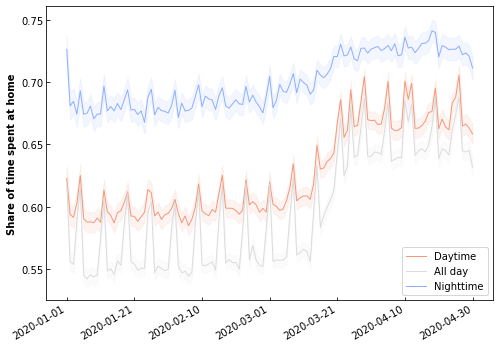

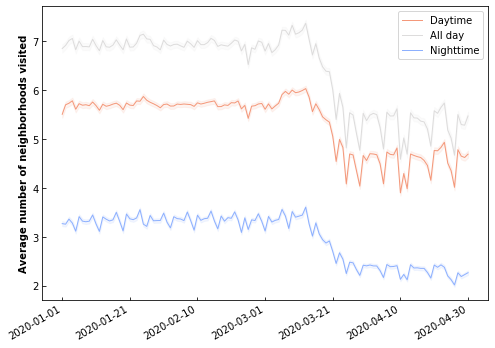

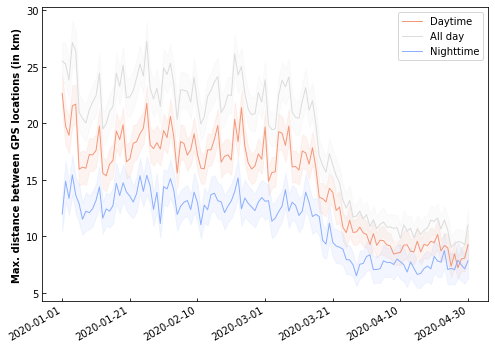

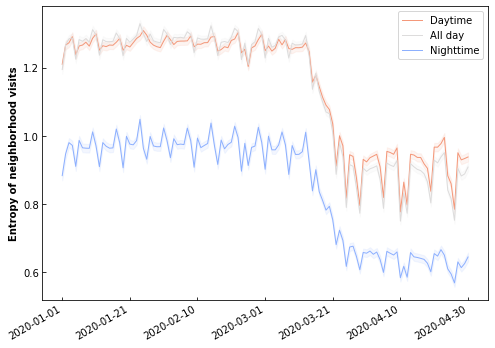

In [155]:
for (df_date,df_daytime,df_nighttime,col1,col2,agg,y_label) in zip(
[duration_date_id,n_admin_date_id,distances_date_id,entropy_date_id],
[duration_daytime_id,n_admin_daytime_id,distances_daytime_id,entropy_daytime_id],
[duration_nighttime_id,n_admin_nighttime_id,distances_nighttime_id,entropy_nighttime_id],
['pct_t','pct_unique','max_distance','entropy'],
['n_home','n_pings','n_pings','n_pings'],
['mean','mean','mean','mean'],
[
'Share of time spent at home',
'Average number of neighborhoods visited',
'Max. distance between GPS locations (in km)',
'Entropy of neighborhood visits',
],
):
    dfs=[df_daytime,df_date,df_nighttime].copy()
    users_activity(dfs,active_ids,col1,col2,y_label,agg)

# Demographics

In [13]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'primary_home'))
primary_home = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 2 sec


In [14]:
print('Import')
start = timer()
admin=gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
print("Done in", round(timer()-start), "sec")  

Import
Done in 73 sec


In [15]:
def get_coords(df):
    df['latitude']=df['point'].apply(lambda x:x['latitude'])
    df['longitude']=df['point'].apply(lambda x:x['longitude'])
    return df.drop('point',1)

In [106]:
print('Merge admin and home data')
start = timer()
primary_home=get_coords(primary_home)
primary_home=gpd.GeoDataFrame(primary_home,geometry=gpd.points_from_xy(primary_home.longitude,primary_home.latitude))
primary_home.crs='epsg:4326'
geocoded_home=gpd.sjoin(primary_home[['cuebiq_id','geometry']],admin,op='intersects')
geocoded_home=geocoded_home[geocoded_home['cuebiq_id'].isin(active_ids)].copy()
for col in demographics:
    try:
        geocoded_home[col+'_quantile']=pd.qcut(geocoded_home[col],10,range(1,11))
    except:
        pass
print("Done in", round(timer()-start), "sec")  

Merge admin and home data
Done in 13 sec


In [108]:
def activity_by_demographics(df_date,df_date_demog,ids,col1,col2,col3,y_label,values,names):
    fig,ax=plt.subplots(figsize=(8,6))
    data=df_date[(df_date[col2]>min_pings)&(df_date['cuebiq_id'].isin(ids))].groupby('date')[col1].agg(['mean','sem'])
    data['mean'].plot(ax=ax,linewidth=1,color='k',label='All users')
    plt.fill_between(data.index, data['mean']-2*data['sem'],data['mean']+2*data['sem'],alpha=0.1,color='k')
    for i,(val,name) in enumerate(zip(values,names)):
        if col3==city_id:
            color=sns.color_palette("hls", len(values))[i]
        else:
            color=sns.color_palette("coolwarm", len(values))[i]
        data=df_date_demog[(df_date_demog[col2]>=min_pings)&(df_date_demog['cuebiq_id'].isin(ids))].groupby([col3,'date'])[col1].agg(['mean','sem']).loc[val]
        data['mean'].plot(ax=ax,linewidth=1,color=color,label=name)
        plt.fill_between(data.index,data['mean']-2*data['sem'],data['mean']+2*data['sem'],alpha=0.1,color=color)
    ax.tick_params(which='both',direction='in',pad=3)
    ax.locator_params(axis='y',nbins=6)
    ax.set_xlabel('')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.legend(loc='best')
    fig.autofmt_xdate()
    print(y_label.replace(' ','-').lower()+'-by-'+col3.replace('_','-'))
    plt.savefig(os.path.join(path_to_data+'/../fig',country,y_label.replace(' ','-').lower()+'-by-'+col3.replace('_','-')+'.png'),bbox_inches='tight')

share-of-time-spent-at-home-by-WEALTH-INDEX-quantile
share-of-time-spent-at-home-by-UC-NM-MN
average-number-of-neighborhoods-visited-by-WEALTH-INDEX-quantile
average-number-of-neighborhoods-visited-by-UC-NM-MN
max.-distance-between-gps-locations-(in-km)-by-WEALTH-INDEX-quantile
max.-distance-between-gps-locations-(in-km)-by-UC-NM-MN
entropy-of-neighborhood-visits-by-WEALTH-INDEX-quantile
entropy-of-neighborhood-visits-by-UC-NM-MN


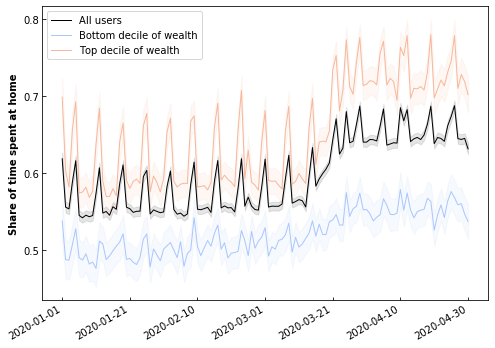

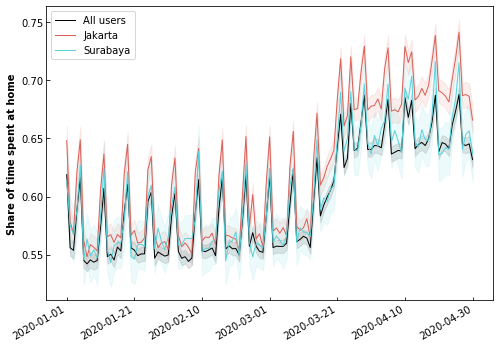

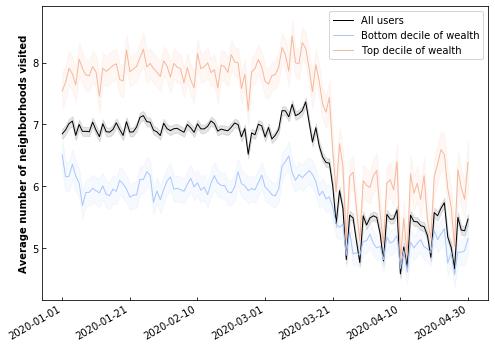

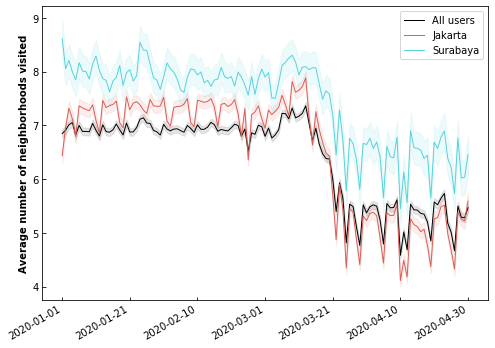

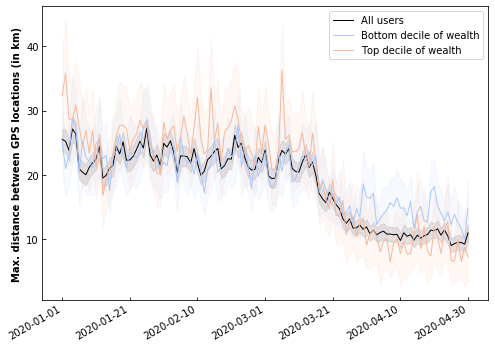

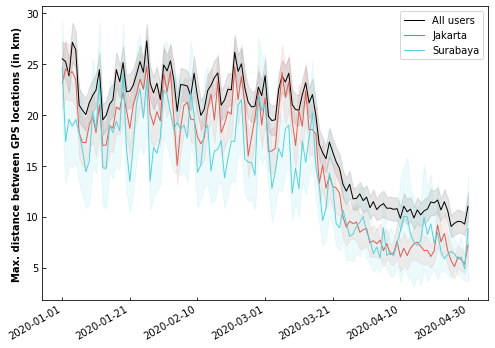

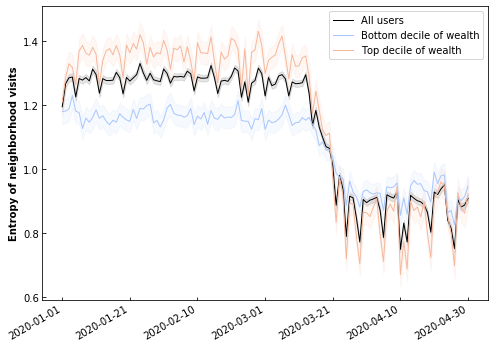

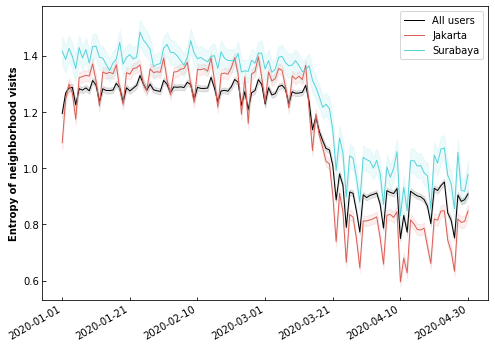

In [156]:
for (df_date,col1,col2,y_label) in zip(
[duration_date_id,n_admin_date_id,distances_date_id,entropy_date_id],
['pct_t','pct_unique','max_distance','entropy'],
['n_home','n_pings','n_pings','n_pings'],
[
'Share of time spent at home',
'Average number of neighborhoods visited',
'Max. distance between GPS locations (in km)',
'Entropy of neighborhood visits',
],
):
    if 'date' not in df_date.columns:
        df_date.reset_index(level='date',inplace=True)
    if 'cuebiq_id' not in df_date.columns:
        df_date.reset_index(level='cuebiq_id',inplace=True)
    df_date_demog=df_date.merge(geocoded_home,on='cuebiq_id')
    for (col3,values,names) in zip(
    ['WEALTH_INDEX_quantile',city_id],
    [[1,10],
     geocoded_home.UC_NM_MN.value_counts().index[:2]],
    [['Bottom decile of wealth','Top decile of wealth'],
     geocoded_home.UC_NM_MN.value_counts().index[:2]]):
        activity_by_demographics(df_date,df_date_demog,active_ids,col1,col2,col3,y_label,values,names)